## Lab: Customer Segmentation Using Clustering

Motivation

Customer segmentation is a crucial task in marketing, allowing businesses to understand customer behavior and tailor their strategies accordingly. In this lab, you will perform customer segmentation using K-Means clustering and Gaussian Mixture Models (GMM) on the Online Retail dataset. This dataset consists of transactional data from an e-commerce retailer, and your goal is to cluster customers based on their purchasing behavior.

To achieve this, you will:

* Extract key customer attributes using the Recency, Frequency, and Monetary (RFM) model.
* Determine the optimal number of clusters using Elbow Method (WCSS for K-Means) and Bayesian Information Criterion (BIC for GMM).
* Apply K-Means and GMM clustering to segment customers.
* Evaluate clustering performance using Silhouette Scores.
* Visualize clustering results using Principal Component Analysis (PCA).
T
his lab is auto-graded in CodeGrade, so follow the steps carefully.

### Step 0: Load and Prepare the Dataset (Provided)
The code for this step is already given. It performs the following:

* Imports necessary libraries, including KMeans and GaussianMixture for clustering.
* Loads the Online Retail dataset from a CSV file.
* Drops missing CustomerID values, as we need customer-level segmentation.
* Ensures proper data types:
* Converts CustomerID to integers.
* Converts InvoiceDate to datetime format.

No modifications are needed for this step.

In [17]:
# CodeGrade step0

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from datetime import datetime

In [18]:
# CodeGrade step0

# Load Online Retail dataset

df = pd.read_csv('OnlineRetail.csv', encoding='latin1')

# Drop rows with missing CustomerID (as we need customer-level segmentation)
df = df.dropna(subset=['CustomerID'])

# Convert CustomerID to integer
df["CustomerID"] = df["CustomerID"].astype(int)

# Convert InvoiceDate to datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

### Step 1: Compute RFM Features and Normalize Data
Objective: Extract Recency, Frequency, and Monetary (RFM) features and standardize them.

Instructions
* Define a reference date as the latest transaction in the dataset.
* Compute the RFM metrics:
  * Recency: Days since the last purchase.
  * Frequency: Number of unique transactions.
  * Monetary: Total amount spent.
* Rename the columns for clarity: "Recency", "Frequency", "Monetary".
* Remove outliers by ensuring Frequency and Monetary values are greater than zero.
* Use StandardScaler to normalize the RFM features.
* Ensure that the shape of the scaled dataset remains the same.

In [19]:
# CodeGrade step1

# Define a reference date (latest transaction in dataset)
reference_date = df["InvoiceDate"].max()

# Compute Recency, Frequency, and Monetary (RFM)
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",  # Frequency (unique transactions)
    "UnitPrice": "sum"  # Monetary Value (Total spent)
})

# Rename columns for clarity
rfm.columns = ["Recency", "Frequency", "Monetary"]

# Remove negative or zero values (outliers)
rfm = rfm[(rfm["Frequency"] > 0) & (rfm["Monetary"] > 0)]

# Scale
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
# shape
rfm_scaled.shape

(4371, 3)

### Step 2: Determine Optimal Clusters for K-Means (Elbow Method)
Objective: Use Within-Cluster Sum of Squares (WCSS) to determine the best K for K-Means.

Instructions
* Initialize an empty list wcss.
* Loop over values of K from 1 to 9:
* Train a KMeans model with random_state=42 and n_init=10.
* Fit the model to rfm_scaled and store the inertia (WCSS) value.
* Compute and return the mean WCSS value, rounded to 2 decimal places.



In [20]:
# CodeGrade step2

# WCSS for k-means
wcss = []
k_values = range(1,10)

# for loop
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)
# WCSS returned
mean_wcss = round(np.mean(wcss), 2)
print("Mean WCSS:", mean_wcss)


Mean WCSS: 4540.13


Plot the Elbow Method graph:
* X-axis: Number of clusters (K).
* Y-axis: WCSS values.
* Use markers ('o') and a line ('-').

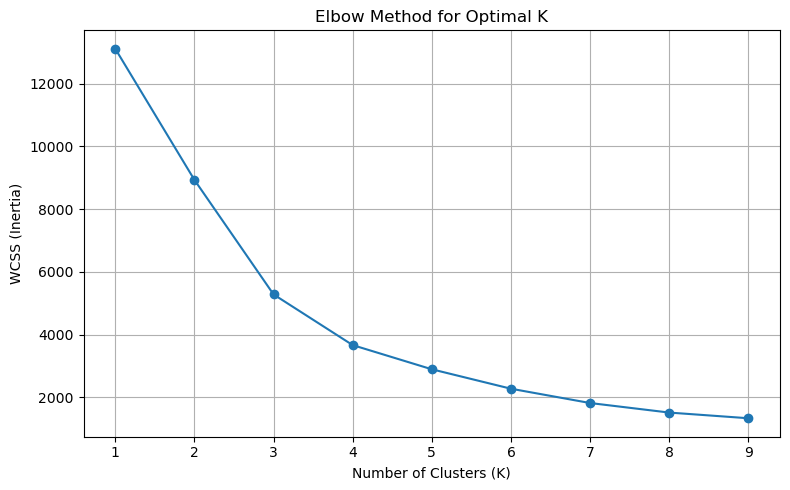

In [21]:
# Plot Elbow Method

plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

### Step 3: Determine Optimal Clusters for GMM (AIC & BIC)
Objective: Use AIC & BIC to determine the best K for GMM.

Instructions
* Initialize empty lists: bic_scores and aic_scores.
* Loop over values of K from 1 to 9:
  * Train a GaussianMixture model with random_state=42 and n_init=10.
  * Fit the model to rfm_scaled and store the BIC and AIC scores.
* Compute and return the difference between the sum of BIC scores and AIC scores, rounded to 0 decimal places.


In [22]:
# CodeGrade step3

bic_scores = []
aic_scores = []

# for loop
for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(rfm_scaled)
    bic_scores.append(gmm.bic(rfm_scaled))
    aic_scores.append(gmm.aic(rfm_scaled))
# Compute and return
bic_aic_diff = round(sum(bic_scores) - sum(aic_scores), 0)
bic_aic_diff

2815.0

Plot the BIC score graph:
* X-axis: Number of clusters (K).
* Y-axis: BIC Score.
* Use markers ('o') and a line ('-').


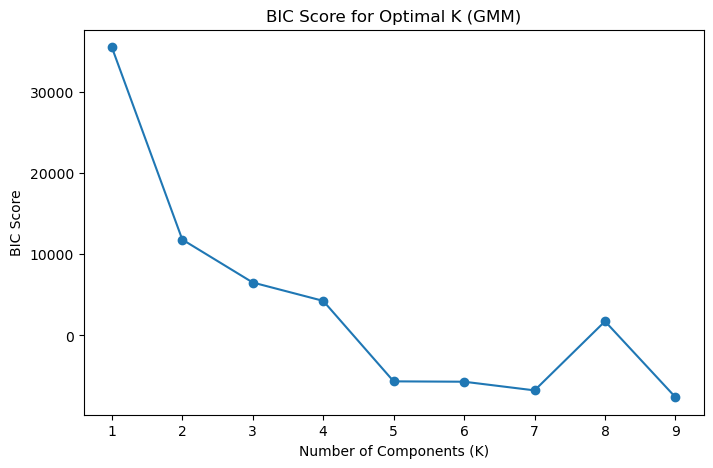

In [23]:
# Plot BIC for GMM
plt.figure(figsize=(8,5))
plt.plot(k_values, bic_scores, marker='o', linestyle='-')
plt.xlabel("Number of Components (K)")
plt.ylabel("BIC Score")
plt.title("BIC Score for Optimal K (GMM)")
plt.show()

You can also plot AIC, or both.

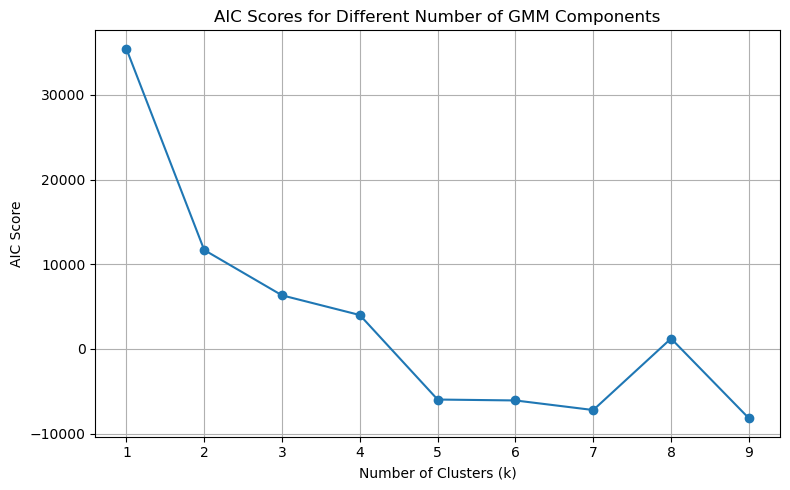

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, aic_scores, marker='o')
plt.title('AIC Scores for Different Number of GMM Components')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('AIC Score')
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 4: Apply K-Means and GMM Clustering
Objective: Apply both K-Means and GMM clustering using the optimal number of clusters.

Instructions
* Set optimal_k  (determined from the previous steps).
* Train a KMeans model and assign clusters to rfm["KMeans_Cluster"].
* Train a GaussianMixture model and assign clusters to rfm["GMM_Cluster"].
* Compute the maximum probability for each cluster and store it in rfm["GMM_Probability"].
* Compute the Silhouette Scores for both clustering methods.
* Return both Silhouette Scores, rounded to 4 decimal places.

In [25]:
# CodeGrade step4

# Optimal k's
optimal_k = 3  # Based on Elbow Method
kmeans = KMeans(n_clusters=3, n_init=20, random_state=1)
rfm["KMeans_Cluster"] = kmeans.fit_predict(rfm_scaled)

gmm = GaussianMixture(n_components=optimal_k, random_state=42, n_init=10)
rfm["GMM_Cluster"] = gmm.fit_predict(rfm_scaled)
rfm["GMM_Probability"] = gmm.predict_proba(rfm_scaled).max(axis=1)

# Silhouette Scores

silhouette_kmeans = silhouette_score(rfm_scaled, rfm["KMeans_Cluster"])
silhouette_gmm = silhouette_score(rfm_scaled, rfm["GMM_Cluster"])

# Return asked for output
print(f"KMeans Silhouette Score: {silhouette_kmeans:.3f}")
print(f"GMM Silhouette Score: {silhouette_gmm:.3f}")


KMeans Silhouette Score: 0.572
GMM Silhouette Score: 0.187


### Step 5: Visualize Clusters with PCA
Objective: Reduce dimensions and compare K-Means vs. GMM clustering results.

Instructions
* Apply PCA (Principal Component Analysis) to reduce rfm_scaled to two dimensions (n_components=2).
* Store the transformed dataset in rfm_pca.
* Return the maximum absolute value in rfm_pca, rounded to 0 decimal places.

In [26]:
# CodeGrade step5

# Perform PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)


Create two scatter plots:
* K-Means clustering results:
  * X-axis: Principal Component 1.
  * Y-axis: Principal Component 2.
  * Color the points based on their K-Means cluster.
* GMM clustering results:
  * X-axis: Principal Component 1.
  * Y-axis: Principal Component 2.
  * Color the points based on their GMM cluster.
* Use cmap='viridis', marker 'o', and edgecolor='k'.
* Display both plots side by side for direct comparison.

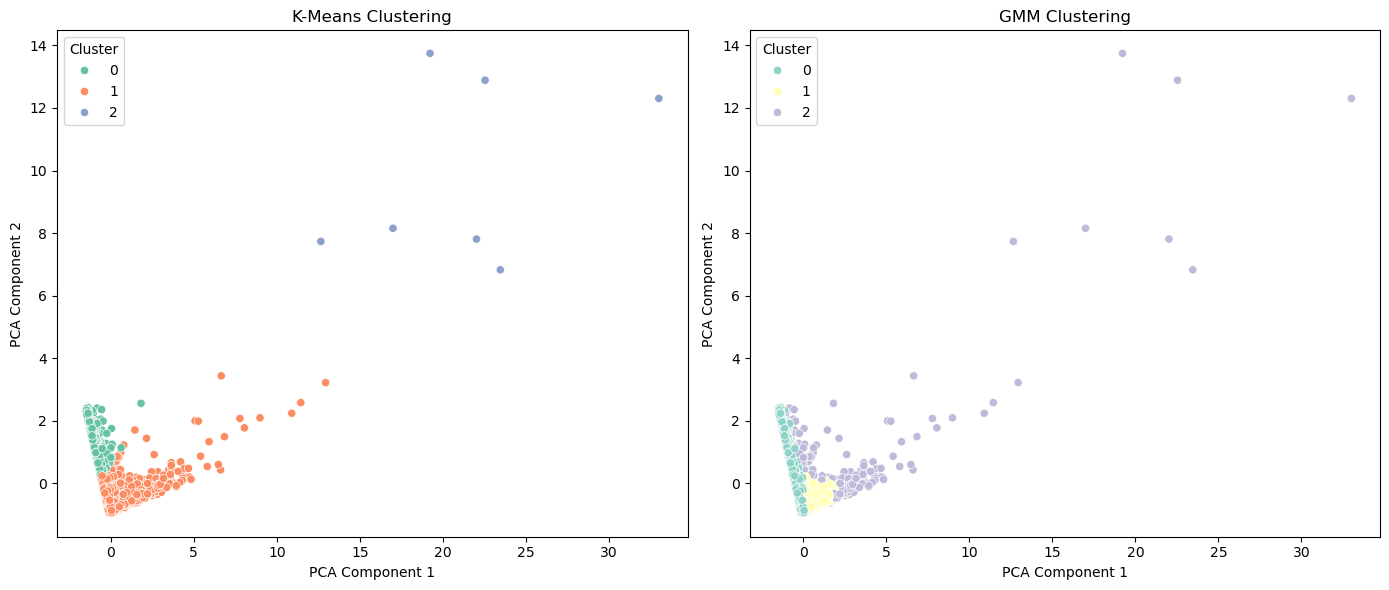

In [27]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


# K-Means Clustering Plot
sns.scatterplot(
    x=rfm_pca[:, 0],
    y=rfm_pca[:, 1],
    hue=rfm["KMeans_Cluster"],
    palette="Set2",
    ax=axes[0]
)
axes[0].set_title("K-Means Clustering")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].legend(title="Cluster")

# GMM Clustering Plot
sns.scatterplot(
    x=rfm_pca[:, 0],
    y=rfm_pca[:, 1],
    hue=rfm["GMM_Cluster"],
    palette="Set3",
    ax=axes[1]
)
axes[1].set_title("GMM Clustering")
axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 2")
axes[1].legend(title="Cluster")

# Show the plots
plt.tight_layout()
plt.show()